In [115]:
import os
import math
import re
from itertools import compress

from subprocess import Popen, PIPE

import numpy as np
from scipy.ndimage import correlate
from scipy.interpolate import griddata

from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches

from ipywidgets import IntProgress

# Parsing stored results

In [3]:
def parse_loc_tuple (tuple_string):
    tup = re.match("\(([\-]?[0-9]+), ([\-]?[0-9]+), ([\-]?[0-9]+)\)", tuple_string).groups()
    tup = tuple(map(int, tup))
    return tup

def load_previous_results (filename):
    results = {}

    with open(filename, "r") as file:
        for line in file:
            loc, time = line.split("\t")
            loc  = parse_loc_tuple (loc)
            time = float(time)

            results[loc] = time
    
    return results

In [4]:
#https://stackoverflow.com/questions/49515085/python-garbage-collection-sometimes-not-working-in-jupyter-notebook
def my_reset(*varnames):
    globals_ = globals()
    to_save = {v: globals_[v] for v in varnames}
    to_save['my_reset'] = my_reset  # lets keep this function by default
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)

In [5]:
results = load_previous_results ("legjobb2.txt")

# Grid helper functions:

In [6]:
def simplify_loc (loc):
    if loc[1] % 2 == 0 and loc[2] % 2 == 0 and loc[0] > 0:
        return simplify_loc((loc[0]-1, loc[1]//2, loc[2]//2))
    else:
        return tuple(loc)

def location_to_2d (loc, size=(2 * math.pi, 2 * math.pi)):
    return [loc[1] / 2.**loc[0] * size[0], loc[2] / 2.**loc[0] * size[1]]

In [285]:
neighbourhood_sub_grid = [0, 0, 4]

def get_neighbourhood (loc, half_sizes = neighbourhood_sub_grid):
    
    neighbourhood = set()
    
    for extra_depth, half_size in enumerate(half_sizes, 1):
        depth = loc[0] + extra_depth
        
        x, y = np.indices((half_size * 2 + 1, half_size * 2 + 1)) - half_size
        x = x + loc[1] * 2**extra_depth
        y = y + loc[2] * 2**extra_depth
        
        neighbourhood |= set(map(lambda xy: simplify_loc((depth,) + xy), zip(x.ravel(), y.ravel())))
    
    return list(neighbourhood)

default_sub_grid_depth = 2

def get_sub_grid (loc, depth = default_sub_grid_depth, extra_padding = 0):
    if depth == 0:
        half_size = extra_padding
    else:
        half_size = 2**(depth-1) + extra_padding
    
    x, y = np.indices((half_size * 2 + 1, half_size * 2 + 1)) - half_size
    depth_arr = np.ones_like (x) * (loc[0] + depth)
    
    x += loc[1] * 2**depth
    y += loc[2] * 2**depth
    
    return np.dstack ((depth_arr, x,y))

def get_parent_grid (loc, half_size = 1):
    ret = []
    
    for up in range(loc[0]):
        x, y = np.indices((half_size * 2 + 1, half_size * 2 + 1)) - half_size
        depth_arr = np.ones_like (x) * (loc[0] - up)
        
        x += loc[1] // 2**up
        y += loc[2] // 2**up
        
        ret.append (np.dstack ((depth_arr, x,y)).reshape((half_size * 2 + 1)**2, 3))
    
    return set(map(tuple, np.vstack (ret)))

In [8]:
def is_outside (loc):
    return 2**(loc[0]-1) <= max(abs(loc[1]), abs(loc[2])) or loc[1] > 0

def is_part_of_fractal (results, t_cutoff=19):
    return (results > t_cutoff)

# Running the c++ code

In [9]:
def read_results_from_pipe ():
    results = []
    
    num_lines = int(pipe.stdout.readline())
    print ("Reading %i lines" % num_lines)

    for _ in range(num_lines):
        results.append (float(pipe.stdout.readline ()))
    
    return results

def run_simu_chunk (locations):
    locations_string = list(map (lambda loc: "%f %f" % tuple(location_to_2d (loc)), locations))    
    locations_string = str(len(locations)) + "\n" + "\n".join(locations_string) + "\n"
    
    pipe.stdin.write(bytes(locations_string.encode("utf8")))
    pipe.stdin.flush ()
    
    results = read_results_from_pipe ()
    
    return dict(zip (map(simplify_loc, locations), results))

def run_simu (locations):
    split_num = math.ceil(len(locations) / 512.0**2)
    arrays = np.array_split (locations, split_num)
    
    print ("Running simulation in %i parts" % split_num)
    
    results = {}
    
    for ind, array in enumerate (arrays):
        print ("(%i/%i)Waiting for simulation..." % (ind, split_num))
        
        array = list(map(tuple, array))
        results.update (run_simu_chunk (array))
    
    return results

# Searching algorithm

In [10]:
kernel_half_size = 1
correlation_kernel = -1 * np.ones ((kernel_half_size * 2 + 1, kernel_half_size * 2 + 1))
correlation_kernel[kernel_half_size, kernel_half_size] = (2*kernel_half_size+1)**2 - 1

parent_level_half_size = 2

def find_edges (neighbourhood_results):
    return correlate (neighbourhood_results, correlation_kernel) != 0

def register_edges (set_of_edge_locs):
    global unprocessed
    unprocessed |= set_of_edge_locs

def process_location (loc):
    global processing, results, processed
    
    if loc in processed:
        return
    
    if is_outside (loc):
        unprocessed.remove (loc)
        results[loc] = 1000
        return
    
    if simplify_loc(loc) not in results:
        processing.add (simplify_loc (loc))
    
    #depth
    neighbourhood = get_sub_grid (loc, default_sub_grid_depth, extra_padding = kernel_half_size)
    
    length = neighbourhood.shape[0]
    neighbourhood_list = neighbourhood.reshape ((length**2, 3))
    
    missing_bools = list(map(lambda l: simplify_loc(l) not in results, neighbourhood_list))
    
    if np.any (missing_bools):
        processing |= set(map(simplify_loc, compress(neighbourhood_list, missing_bools)))
        return
    
    neighbourhood_results = np.array([results[simplify_loc(loc)] for loc in neighbourhood_list]).reshape ((length, length))
    neighbourhood_results = is_part_of_fractal (neighbourhood_results)
    
    is_on_edge = find_edges (neighbourhood_results)
    register_edges (set(map(tuple, neighbourhood[is_on_edge])))
    
    #if found any edges in self then check the neighbours too
    if np.any(is_on_edge):
        #breadth
        same_level_neigs = get_sub_grid (loc, 0, parent_level_half_size)
        
        #backwards
        for neig in same_level_neigs.reshape ((2*parent_level_half_size+1)**2, 3):
            register_edges (get_parent_grid (neig, 0))
    
    unprocessed.remove (loc)
    processed.add (loc)

# Running the whole thing

In [20]:
def scatter_plot (locs, is_frac, title):
    plt.figure (figsize=(5,10))
    plt.title(title)
    plt.scatter (locs[:,0], locs[:,1], c=is_frac)
    plt.xlabel ("$\\theta_1$")
    plt.ylabel ("$\\theta_2$")
    plt.xlim(-3.14, 0)
    plt.ylim(-3.14, 3.14)
    plt.show()

def density_plot (locs, is_frac, title, save = False):
    plt.figure (figsize=(6,10))
    vals, _, _, _ = plt.hist2d (locs[:,0], locs[:,1], bins=1000, norm=LogNorm());
    if title:
        plt.title (title)
    plt.xlim(-3.14, 0)
    plt.ylim(-3.14, 3.14)
    plt.xlabel ("$\\theta_1$")
    plt.ylabel ("$\\theta_2$")
    cbar = plt.colorbar ()
    cbar.set_label ("# of fractal points")
    if save:
        plt.savefig ("figures/density.png")
    plt.show ()

def get_arrays (results = results):
    locs     = np.array(list(results.keys()))
    pos      = np.array(list(map(location_to_2d, locs)))
    times    = np.array(list(results.values()))
    is_frac  = is_part_of_fractal(times)
    
    return locs, pos, times, is_frac

def plot_current (title = None):
    _, pos, _, is_frac = get_arrays ()
    
    scatter_plot (pos, is_frac, title + "\nScatter")
    density_plot (pos, is_frac, title + "\nDensity")

In [ ]:
processing = set ()
starting_depth = 4
global unprocessed
unprocessed = set (map(tuple, get_sub_grid ((0,0,0), starting_depth).reshape(((2**starting_depth+1)**2, 3))))
processed = set ()
results = {}

if "pipe" not in globals() or pipe.poll():
    pipe = Popen ("./pendulum-dimension", stdin=PIPE, stdout=PIPE, shell=True)

#levels = {}
#levels_ = {}

for step in range(100):
    print ()
    print ("___ Starting step %i ___" % step)
    
    processing = set ()
    
    print ("%i unprocessed locations" % len(unprocessed))
    print ("%i results" % len(results))
    print ()
    
    need_to_process = list(filter(lambda x: not is_outside(x), unprocessed - processed))
    min_lvl = min(need_to_process, key=lambda x: x[0])[0]
    #do not allow more than 3 level difference
    process_now = list(filter (lambda x: x[0] <= min_lvl+3, need_to_process))
    
    print ("Processing %i locations" % len(process_now))
    
    for loc in process_now:
        process_location (loc)
    
    processing |= {simplify_loc (loc) for loc in unprocessed} - results.keys()
    
    if len(processing) == 0:
        if len(unprocessed) == 0:
            print ("nothing left to do")
            break
        else:
            continue
    
    print ("Sending %i points" % len(processing))
    results.update(run_simu (list(processing)))
    
    print ("Generating plot...")
    plot_current (str(step))
    
    print ("Saving results...")
    save_current ()
    
    #levels.update({*zip (processing, [step] * len(processing))})
    #levels_.update({*zip (unprocessed, [step] * len(unprocessed))})

# Analysing results

In [12]:
def cut_off_at_depth (depth):
    res_small = {}
    
    for loc, time in results.items():
        if loc[0] <= depth:
            res_small[loc] = time
    
    return res_small

In [13]:
locs, pos, times, is_frac = get_arrays ()

## Helper functions

In [14]:
def get_max_lvl (locs):
    return locs[:, 0].max ()

def get_full_array (pos, times, max_lvl):
    half_size   = 2**(max_lvl-1)
    side_length = 2 * half_size + 1
    
    index_grid = np.dstack (np.indices([half_size+1, side_length]))
    index_arr = index_grid.reshape(((half_size+1)*side_length, 2))
    
    grid_points = (index_arr - np.array([half_size, half_size])) / side_length * 2 * math.pi
    
    res_points = griddata (pos, times, grid_points, method="nearest")
    res_grid = res_points.reshape([half_size+1, side_length])
    
    return grid_points, res_points, res_grid

## Visualizing the fractal

In [15]:
grid_points, res_points, res_grid = get_full_array (pos, times, get_max_lvl (locs))

### different levels

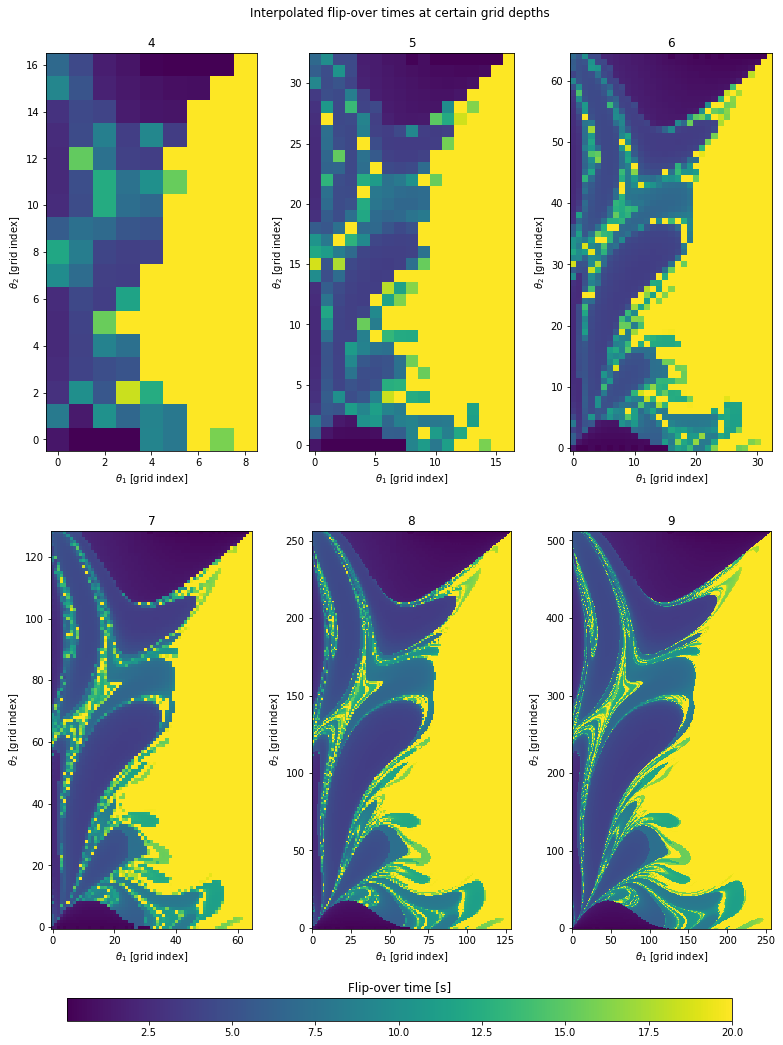

In [16]:
depths = np.arange(4, 10)

fig, axes = plt.subplots (2, len(depths)//2, figsize=(2.2*len(depths), 16))

for i, depth in enumerate(depths):
    ax = axes[2*i//len(depths)][i % (len(depths)//2)]
    
    res_small = cut_off_at_depth (depth)
    
    locs_, pos_, times_, is_frac_ = get_arrays (res_small)
    
    _, _, res_grid_ = get_full_array (pos_, times_, get_max_lvl (locs_))
    
    im = ax.imshow(res_grid_.T, origin="lower")
    ax.set_xlabel ("$\\theta_1$ [grid index]")
    ax.set_ylabel ("$\\theta_2$ [grid index]")
    ax.set_title (str(depth))

fig.subplots_adjust(bottom=0.18, top=0.94)
cbar_ax = fig.add_axes([0.15, 0.10, 0.7, 0.02])
cbar_ax.set_title("Flip-over time [s]")
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")

fig.savefig ("figures/depth_subplots.png", bbox_inches="tight")

fig.suptitle ("Interpolated flip-over times at certain grid depths");

### cutoff

In [81]:
def set_ticks_and_labels (ax, size):
    tick_inds = np.arange(0, size//2+1, size//8)
    ax.set_xticks(tick_inds)
    ax.set_xticklabels (["%.2f" % x for x in np.linspace(-math.pi, 0, len(tick_inds))])
    ax.set_xlabel ("$\\theta_1$")
    
    tick_inds = np.arange(0, size+1, size//8)
    ax.set_yticks(tick_inds)
    ax.set_yticklabels (["%.2f" % x for x in np.linspace(-math.pi, math.pi, len(tick_inds))])
    ax.set_ylabel ("$\\theta_2$")

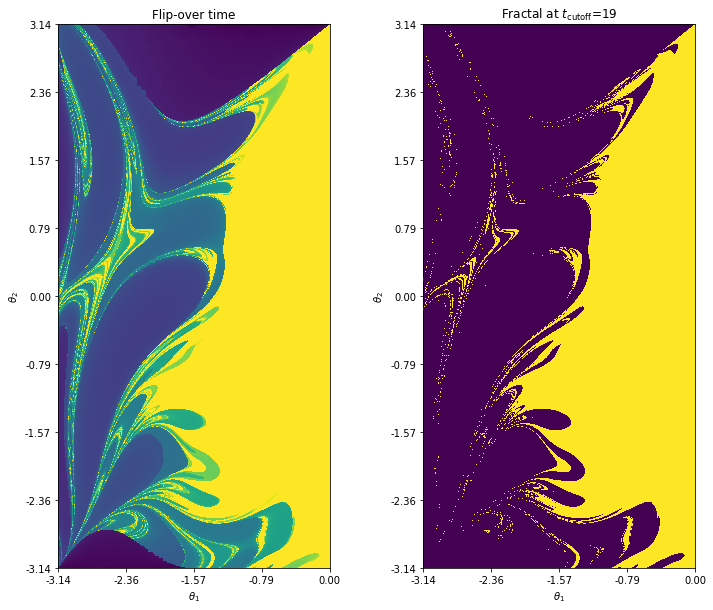

In [82]:
fig, ax = plt.subplots (1, 2, figsize=(12, 10))

ax[0].imshow (res_grid.T, origin='lower')
ax[1].imshow (is_part_of_fractal(res_grid).T, origin='lower')

set_ticks_and_labels(ax[0], 8192)
set_ticks_and_labels(ax[1], 8192)

ax[0].set_title ("Flip-over time")
ax[1].set_title ("Fractal at $t_{\mathrm{cutoff}}$=19")

fig.savefig ("figures/cutoff.png", bbox_inches="tight")

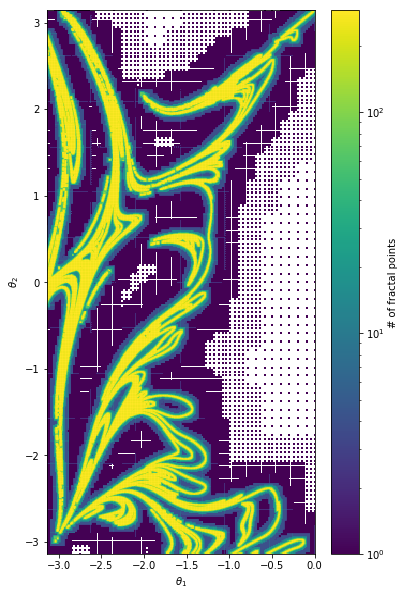

In [22]:
density_plot (pos, is_frac, None, True)

## Zoom-ins

In [23]:
def in_range (pos, x0, x1, y0, y1):
    return np.logical_and (np.logical_and (pos[:, 0] > x0, pos[:, 0] < x1),
                           np.logical_and (pos[:, 1] > y0, pos[:, 1] < y1))

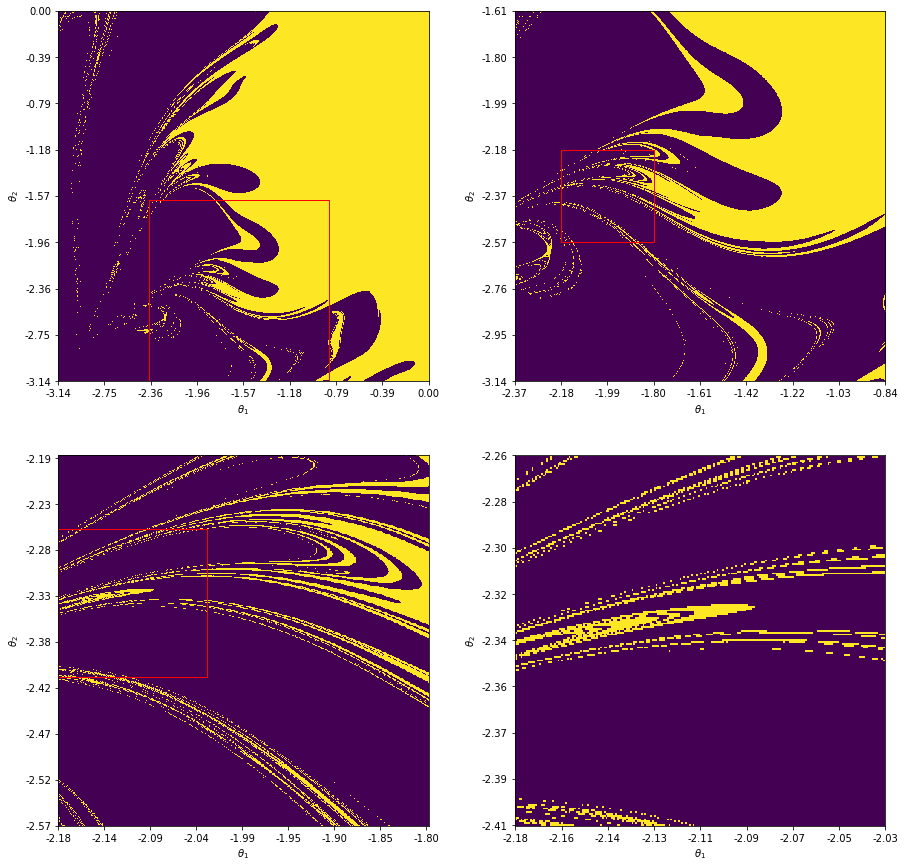

In [50]:
def add_local_ticks_and_label (ax, x0, x1, y0, y1, res = 8192):
    tick_inds = np.arange(0, x1-x0 + 1, (x1-x0)//8)
    thetas = ((tick_inds + x0) / res - 0.5) * math.pi * 2
    
    ax.set_xticks (tick_inds)
    ax.set_xticklabels (["%.2f" % theta for theta in thetas])
    ax.set_xlabel ("$\\theta_1$")
    
    
    tick_inds = np.arange(0, y1-y0 + 1, (y1-y0)//8)
    thetas = ((tick_inds + y0) / res - 0.5) * math.pi * 2
    
    ax.set_yticks (tick_inds)
    ax.set_yticklabels (["%.2f" % theta for theta in thetas])
    ax.set_ylabel ("$\\theta_2$")

fig, ax = plt.subplots (2, 2, figsize=(15, 15))

#first
ax[0][0].imshow (is_part_of_fractal(res_grid[:, :4096]).T, origin='lower')
add_local_ticks_and_label (ax[0][0], 0, 4096, 0, 4096)

rect = patches.Rectangle((1000, 0), 2000, 2000,linewidth=1, edgecolor='red', facecolor='none')
ax[0][0].add_patch (rect)

#second
ax[0][1].imshow (is_part_of_fractal(res_grid[1000:3000, 0:2000]).T, origin='lower')
add_local_ticks_and_label (ax[0][1], 1000, 3000, 0, 2000)

rect = patches.Rectangle((250, 750), 500, 500,linewidth=1, edgecolor='red', facecolor='none')
ax[0][1].add_patch (rect)

#third
ax[1][0].imshow (is_part_of_fractal(res_grid[1250:1750, 750:1250]).T, origin='lower')
add_local_ticks_and_label (ax[1][0], 1250, 1750, 750, 1250)

rect = patches.Rectangle((0, 200), 200, 200,linewidth=1, edgecolor='red', facecolor='none')
ax[1][0].add_patch (rect)

#fourth
ax[1][1].imshow (is_part_of_fractal(res_grid[1250:1450, 950:1150]).T, origin='lower')
add_local_ticks_and_label (ax[1][1], 1250, 1450, 950, 1150)

fig.savefig ("figures/zoom-in_1.png", bbox_inches="tight")

plt.show()

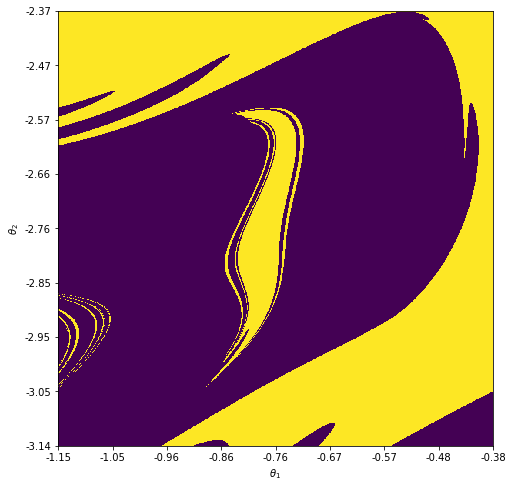

In [105]:
plt.figure (figsize=(8,8))
plt.imshow (is_part_of_fractal(res_grid[2600:3600, :1000]).T, origin='lower')
add_local_ticks_and_label (plt.gca(), 2600, 3600, 0, 1000)
plt.savefig("figures/island.png", bbox_inches="tight")

# Fractal dimension

In [25]:
frac_pos = grid_points[is_part_of_fractal (res_points)]

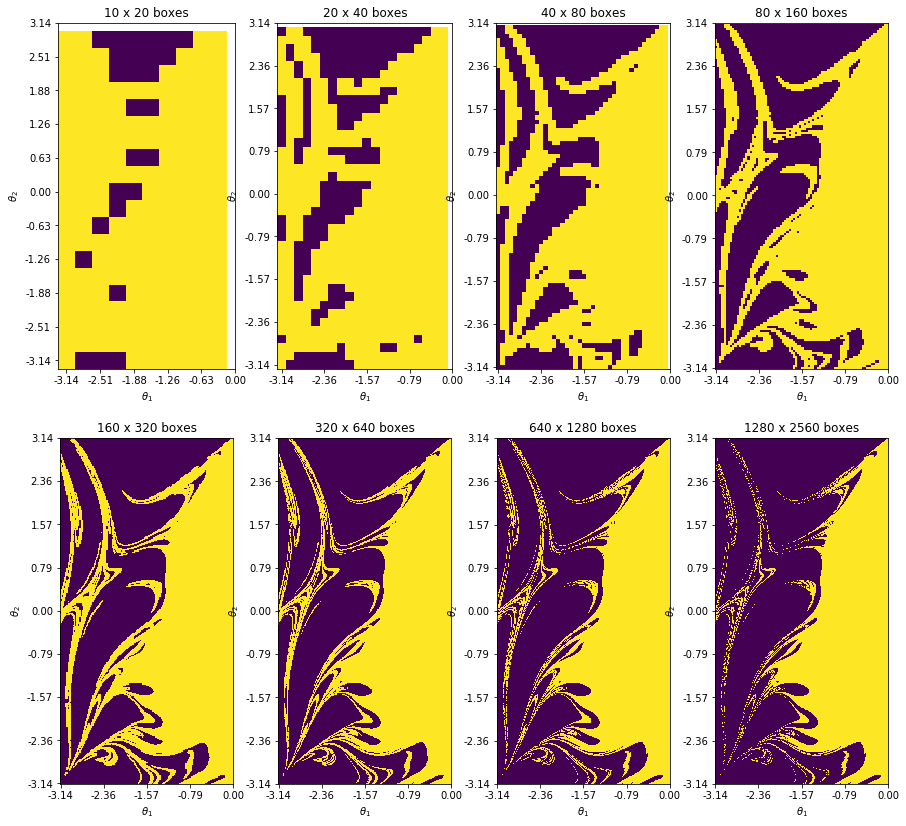

In [248]:
epsilons = [10, 20, 40, 80, 160, 320, 640, 1280, 2000, 4000, 8000]
box_num = []

fig, axes = plt.subplots(2, 4, figsize=(15,14))

for i, scale in enumerate(epsilons):
    nums, _, _ = np.histogram2d(frac_pos[:, 0], frac_pos[:,1], bins=(scale,scale*2))
    
    if i < 8:
        ax = axes[i // 4][i % 4]
        ax.imshow ((nums > 0).T, origin="bottom")
        set_ticks_and_labels (ax, scale*2)
        ax.set_title ("%i x %i boxes" % (scale, scale*2))
    
    box_num.append ((nums > 0).sum())

fig.savefig ("figures/box_counting_whole.png", bbox_inches="tight")

epsilons = np.array(epsilons)*2
box_num  = np.array(box_num)*2

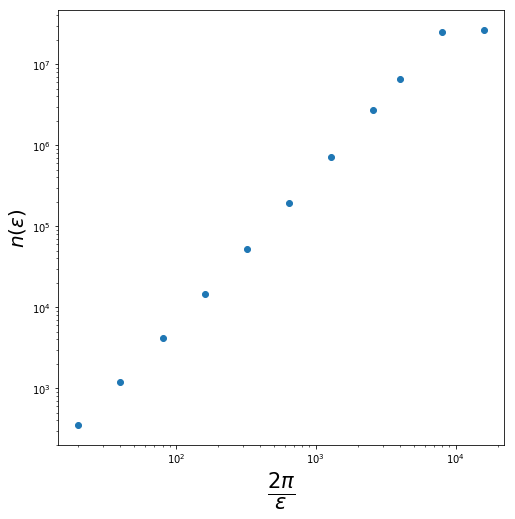

In [249]:
plt.figure (figsize=(8,8))
plt.scatter(np.array(epsilons), box_num)
plt.yscale("log")
plt.xscale("log")

plt.xlabel (r"$\frac{2 \pi}{\epsilon}$", fontsize=30)
plt.ylabel (r"$n(\epsilon)$", fontsize=20)

plt.savefig ("figures/dimension_whole_.eps", bbox_inches="tight")

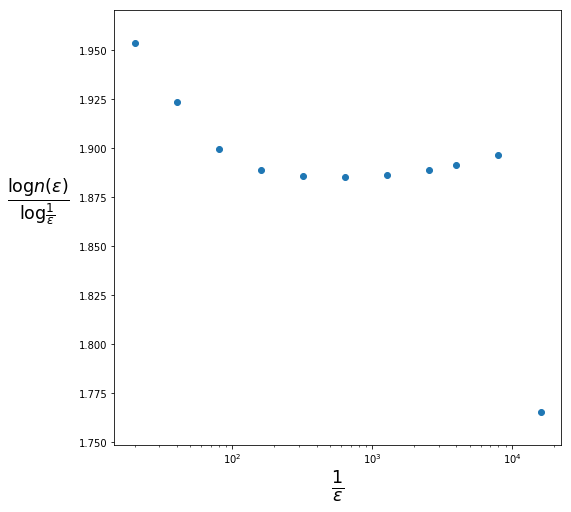

In [250]:
plt.figure (figsize=(8,8))
plt.scatter(np.array(epsilons), np.log(np.array(box_num))/np.log(np.array(epsilons)))
plt.xscale("log")

plt.xlabel (r"$\frac{1}{\epsilon}$", fontsize=25)
plt.ylabel (r"$\frac{\log n(\epsilon)}{\log \frac{1}{\epsilon}}$", fontsize=25, rotation=0, labelpad=40.0)

plt.savefig ("figures/dimension_whole.eps", bbox_inches="tight")

In [252]:
np.log(box_num) / np.log(epsilons)

array([1.95351318, 1.92336574, 1.89937752, 1.88899824, 1.88589751,
       1.88506588, 1.88612061, 1.8887903 , 1.89127713, 1.89634844,
       1.7654299 ])

In [29]:
frac_grid = is_part_of_fractal (res_grid)

In [35]:
kernel_ = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]

frac_edges_grid = correlate (frac_grid, kernel_)

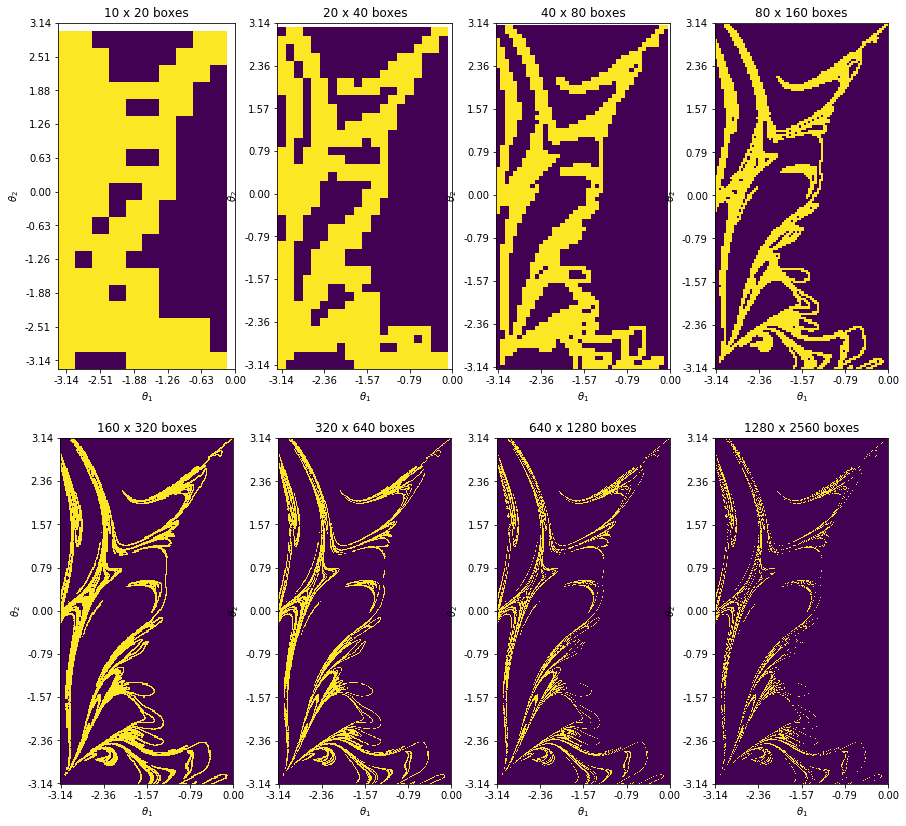

In [241]:
epsilons_edges = [10, 20, 40, 80, 160, 320, 640, 1280, 2000, 4000, 8000]
box_num_edges = []

frac_edges = grid_points [frac_edges_grid.reshape((np.prod(frac_edges_grid.shape[0:2])))]

fig, axes = plt.subplots(2, 4, figsize=(15,14))

for i, scale in enumerate(epsilons_edges):
    nums, _, _ = np.histogram2d(frac_edges[:, 0], frac_edges[:,1], bins=(scale,scale*2))
    
    if i < 8:
        ax = axes[i // 4][i % 4]
        ax.imshow ((nums > 0).T, origin="bottom")
        set_ticks_and_labels (ax, scale*2)
        ax.set_title ("%i x %i boxes" % (scale, scale*2))
    
    box_num_edges.append ((nums > 0).sum())

fig.savefig ("figures/box_counting_edges.png", bbox_inches="tight")

epsilons_edges = np.array(epsilons_edges)*2
box_num_edges  = np.array(box_num_edges)*2

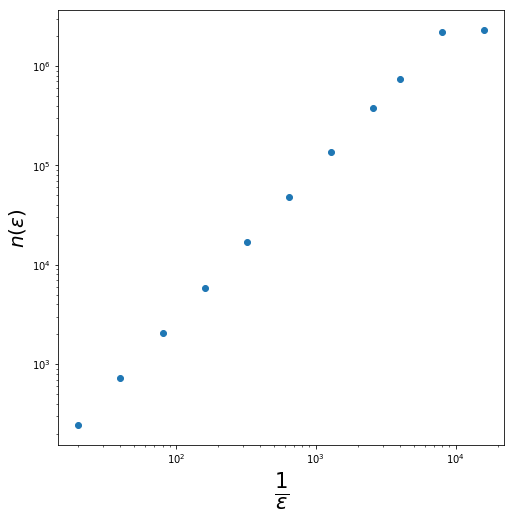

In [242]:
plt.figure (figsize=(8,8))
plt.scatter(np.array(epsilons_edges), box_num_edges)
plt.yscale("log")
plt.xscale("log")

plt.xlabel (r"$\frac{1}{\epsilon}$", fontsize=30)
plt.ylabel (r"$n(\epsilon)$", fontsize=20)

plt.savefig ("figures/dimension_edges_.eps", bbox_inches="tight")

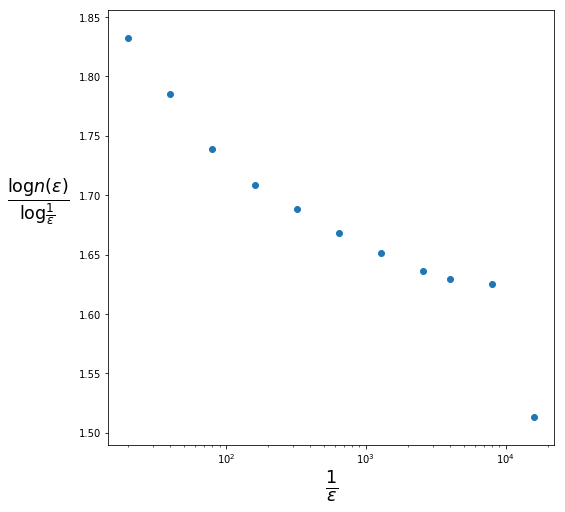

In [244]:
plt.figure (figsize=(8,8))
plt.scatter(np.array(epsilons_edges), np.log(np.array(box_num_edges))/np.log(np.array(epsilons_edges)))
plt.xscale("log")

plt.xlabel (r"$\frac{1}{\epsilon}$", fontsize=25)
plt.ylabel (r"$\frac{\log n(\epsilon)}{\log \frac{1}{\epsilon}}$", fontsize=25, rotation=0, labelpad=40.0)

plt.savefig ("figures/dimension_edges.eps", bbox_inches="tight")

In [247]:
np.log(box_num_edges[-2]) / np.log(epsilons_edges[-2])

1.6256052750764736

In [211]:
(np.log(box_num_edges[-2])-np.log(box_num_edges[-3])) / (np.log(epsilons_edges[-2]/math.pi)-np.log(epsilons_edges[-3]/math.pi))

1.5788811369058233

## Edges

In [1]:
plt.figure(figsize=(40,80))
plt.imshow(frac_edges)
plt.savefig ("figures/edges_medium.png")

NameError: name 'plt' is not defined

# Helper plots

## Visualizing grid

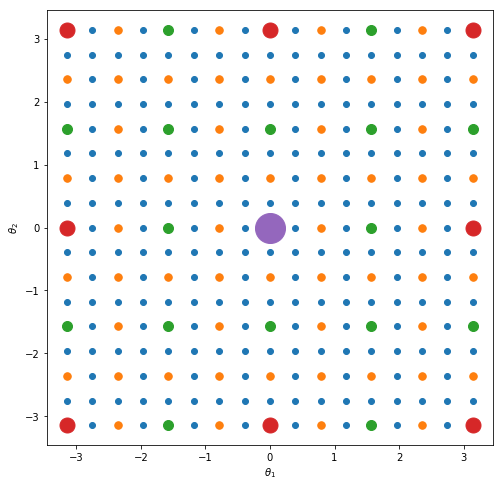

In [286]:
plt.figure (figsize=(8,8))

for d in reversed(range(4)):
    points = np.array(list(map(location_to_2d, get_neighbourhood ((0,0,0), [0]*d + [2**d]))))
    plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2))

plt.plot (0, 0, "o", markersize=30);
plt.xlabel ("$\\theta_1$")
plt.ylabel ("$\\theta_2$");

plt.savefig ("figures/grid_layout.png", bbox_inches="tight")

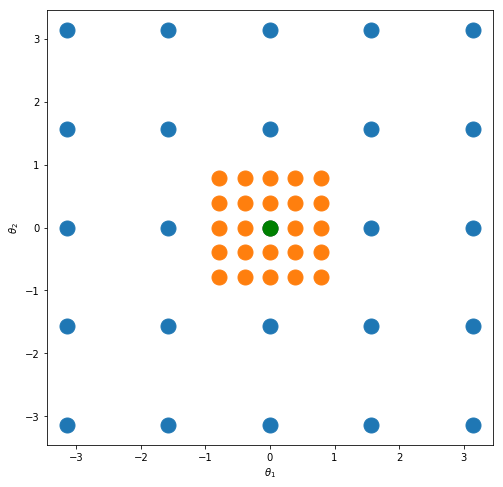

In [287]:
plt.figure (figsize=(8,8))

points = np.array(list(map(location_to_2d, get_neighbourhood ((0,0,0), [0]*3 + [2]))))
plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2), color="C1")


points = np.array(list(map(location_to_2d, get_neighbourhood ((0,0,0), [0]*1 + [2]))))
plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2))

plt.plot (0, 0, "o", markersize=30/(d+2), color="green")

plt.xlabel ("$\\theta_1$")
plt.ylabel ("$\\theta_2$");

plt.savefig ("figures/grid_depth.png", bbox_inches="tight")

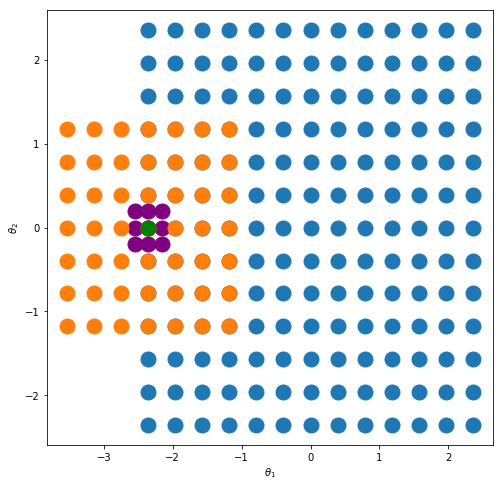

In [307]:
plt.figure (figsize=(8,8))


points = np.array(list(map(location_to_2d, get_neighbourhood ((3,0,0), [6]))))
plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2), color="C0")
points = np.array(list(map(location_to_2d, get_neighbourhood ((4,-6,0), [1]))))
plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2), color="purple")

points = np.array(list(map(location_to_2d, get_neighbourhood ((3,-3,0), [3]))))
plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2), color="C1")

plt.plot (*location_to_2d((3,-3,0)), "o", markersize=30/(d+2), color="green")

plt.xlabel ("$\\theta_1$")
plt.ylabel ("$\\theta_2$");

plt.savefig ("figures/grid_breadth.png", bbox_inches="tight")

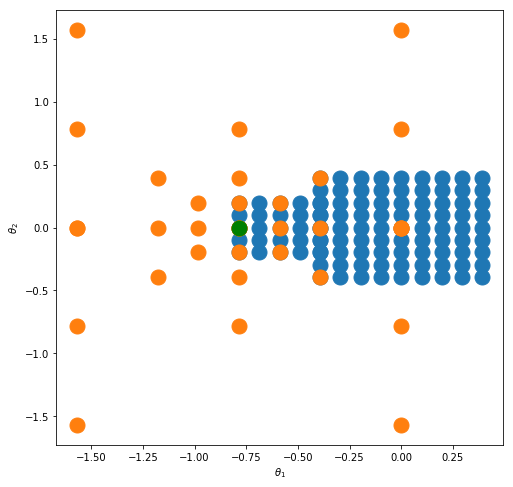

In [351]:
plt.figure (figsize=(8,8))

points = np.array(list(map(location_to_2d, get_neighbourhood ((5,0,0), [4]))))
plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2), color="C0")
#points = np.array(list(map(location_to_2d, get_neighbourhood ((4,-6,0), [1]))))
#plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2), color="purple")

points = np.array(list(map(location_to_2d, get_neighbourhood ((5,-3,0), [2]))))
plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2), color="C0")

points = np.array(list(map(location_to_2d, filter(lambda x: not is_outside(x), get_parent_grid ((5, -4, 0), 1)))))
plt.plot (points[:, 0], points[:, 1], "o", markersize=30/(d+2), color="C1")

plt.plot (*location_to_2d((5,-4,0)), "o", markersize=30/(d+2), color="green")

plt.xlabel ("$\\theta_1$")
plt.ylabel ("$\\theta_2$");

plt.savefig ("figures/grid_backwards.png", bbox_inches="tight")